In [ ]:
import pandas as pd

ods = (
    pd.read_excel(
        "DB AF Completo 1.ods",
    )
    .loc[:, ["ID", "Phenotype"]]
    .rename(columns={"ID": "Patient ID"})
    .dropna(axis=0, how="any")
    .astype({"Patient ID": int})
)
csv = (
    pd.read_csv("lase.csv", sep=",")
    .dropna(axis=0, how="any")
    .astype({"Patient ID": int})
)
display(ods)
csv

,Patient ID,Phenotype
3,9,Persistent
4,10,Paroxysmal
5,11,Persistent
6,12,Persistent
7,13,Persistent
...,...,...
235,218,Parossistica
236,219,Persistente
238,221,Persistente (FLA aty)
260,243,Parossistica


,Patient ID,Entropy,LASE
2,100,0,1.165857
3,101,0,0.849187
4,102,0,1.068471
5,103,0,0.744711
6,104,0,0.995973
...,...,...,...
94,94,0,0.881222
95,95,0,1.195399
96,96,0,1.074315
97,97,0,1.019213


In [42]:
# Join the two dataframes on the "ID" column
merged_df = pd.merge(
    ods.loc[:, ["Patient ID", "Phenotype"]], csv, on="Patient ID", how="inner"
)

phenotype_mapping = {
    "Long standing persistent": "Persistente",
    "Persistente": "Persistente",
    "Parossistica": "Parossistica",
    "Parossistico": "Parossistica",
}
merged_df["Phenotype"] = merged_df["Phenotype"].map(phenotype_mapping)

merged_df

,Patient ID,Phenotype,Entropy,LASE
0,40,Parossistica,0,0.897287
1,41,Parossistica,0,0.888201
2,42,Parossistica,0,1.076546
3,43,Persistente,0,1.158752
4,45,Persistente,0,1.109672
...,...,...,...,...
88,147,Parossistica,0,0.888083
89,148,Parossistica,0,1.028202
90,149,Parossistica,0,1.017426
91,150,Parossistica,0,0.775818


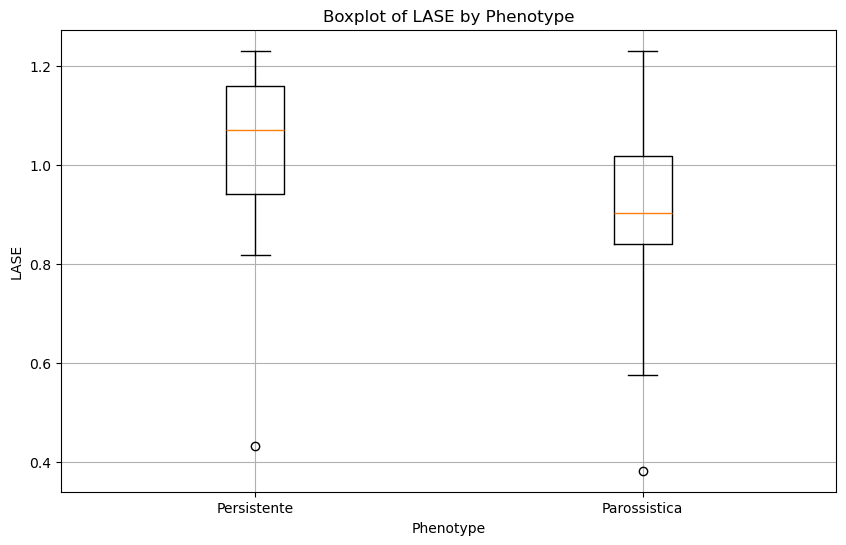

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(
    [
        merged_df[merged_df["Phenotype"] == "Persistente"]["LASE"],
        merged_df[merged_df["Phenotype"] == "Parossistica"]["LASE"],
    ],
    tick_labels=["Persistente", "Parossistica"],
)
plt.title("Boxplot of LASE by Phenotype")
plt.ylabel("LASE")
plt.xlabel("Phenotype")
plt.grid()
plt.show()